# 0. Setup Workspace and Import Packages

In [1]:
your_username = 'BokaiHe'  # username of the person running the code. Reviewers should also change this to their own username.

#To allow the reviewer to access the saved files, provide notebook owner's username here:  
owner_username = 'BokaiHe'  # Reviewer should not change this name

In [2]:
%%capture
!pip install tensorflow
!pip install keras

In [3]:
%%capture
### standard imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import fsspec
### Python file with supporting functions ###
# standard imports
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import sys
# Redirect all low-level stderr output
sys.stderr = open(os.devnull, 'w')

import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth',100)
import csv
import cmocean as cm

# machine learning libraries
import xgboost as xgb     
from xgboost import XGBRegressor

# Change to the parent directory of the current working directory. (Run only once—otherwise it will keep moving up the directory tree)
os.chdir(os.path.dirname(os.getcwd()))
print("Current working directory:", os.getcwd())

# Python file with supporting functions
import lib.residual_utils as supporting_functions
from lib.visualization import *
from lib.bias_figure2 import concat_datasets, XarrayEvaluator
from lib.corr_figure3 import eval_spatial

E0000 00:00:1745300917.730143     780 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745300917.735824     780 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745300917.750824     780 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745300917.750848     780 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745300917.750850     780 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745300917.750852     780 computation_placer.cc:177] computation placer already registered. Please check linka

In [4]:
### Setting the date range to unify the date type ###

# Define date range
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'

# create date vector, adds 14 days to start & end
dates = pd.date_range(start=date_range_start, 
                      end=date_range_end,freq='MS')


init_date = str(dates[0].year) + format(dates[0].month,'02d')
fin_date = str(dates[-1].year) + format(dates[-1].month,'02d')

# 1. NGboost

## 1.1 Model Training

In [5]:
# Install NGBoost library (if not installed)
# %%capture
# !pip install ngboost

### Standard Imports ###
import numpy as np
import pandas as pd
import xarray as xr
import gcsfs
import fsspec
import os
import sys
import datetime
from collections import defaultdict
import random
import matplotlib.pyplot as plt
import csv
import pickle

# NGBoost and ML libraries
from ngboost import NGBRegressor
from ngboost.distns import Normal  # Use normal distribution as base
from ngboost.scores import LogScore  # Use log score as loss function

# Import custom utility functions
import lib.residual_utils as supporting_functions

# Control variable
runthiscell = 0  # 0 = skip, 1 = run all, -1 = run only the first member

if runthiscell: 
    # Load random seeds
    fs = gcsfs.GCSFileSystem()  # Ensure fs object is defined
    random_seeds = np.load(fs.open(path_seeds))   
    
    # Create seed location dictionary - fixed version
    seed_loc_dict = defaultdict(dict)
    
    # Ensure only the dictionary members we want to process are used
    for ens, mem_list in selected_mems_dict.items():
        sub_dictt = dict()
        for no, mem in enumerate(mem_list):
            sub_dictt[mem] = no  # Use member directly as key
        seed_loc_dict[ens] = sub_dictt
    
    # Verify all required keys exist in seed_loc_dict
    for ens, mem_list in selected_mems_dict.items():
        for mem in mem_list:
            if mem not in seed_loc_dict[ens]:
                print(f"Warning: {ens} member {mem} not in seed_loc_dict")
    
    # Validation set proportion
    val_prop = .2  # 20% of training data for validation
    test_prop = .0  # Not used here because X_test is pre-separated
    
    print(datetime.datetime.now())

    # Determine which models and members to run
    if runthiscell == -1:
        print("Review mode: Only running the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]
        first_mem = selected_mems_dict[first_ens][0]
        run_selected_mems_dict = {first_ens: [first_mem]}
    else:
        run_selected_mems_dict = selected_mems_dict
    
    # NGBoost hyperparameters
    ngb_params = {
        'n_estimators': 500,         # Number of boosting rounds
        'learning_rate': 0.05,       # Learning rate
        'natural_gradient': True,    # Use natural gradient
        'minibatch_frac': 0.8,       # Proportion of data used per iteration
        'col_sample': 0.8,           # Feature proportion per tree
        'verbose': False,            # Disable training output
        'Score': LogScore            # Loss function
    }
    
    # Train one NGBoost model for each ensemble member
    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(ens, member)
            
            # Ensure seed_loc is available; otherwise use default
            if member in seed_loc_dict[ens]:
                seed_loc = seed_loc_dict[ens][member]
            else:
                # Use a default value, e.g., 0 or random
                seed_loc = 0
                print(f"Warning: Using default seed_loc 0 for {ens} member {member}")
            
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
            file_path = f"{data_dir}/{fname}"
    
            with fs.open(file_path, 'rb') as filee:
                df = pd.read_pickle(filee)
                df['year'] = df.index.get_level_values('time').year
                df['mon'] = df.index.get_level_values('time').month
                df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)
                
                # Select valid rows
                recon_sel = (
                    ~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)
                ) & (
                    (df[target_sel] < 250) & (df[target_sel] > -250)
                ).to_numpy().ravel()
    
                # SOCAT mask selection
                sel = (recon_sel & (df['socat_mask'] == 1))
                
                # Train/test split based on time
                train_sel = (sel & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
                test_sel  = (sel & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()
                unseen_sel = (recon_sel & (df['socat_mask'] == 0))
    
                # Extract features and target variable
                X = df.loc[sel, features_sel].to_numpy()
                y = df.loc[sel, target_sel].to_numpy().ravel()
    
                Xtrain = df.loc[train_sel, features_sel].to_numpy()                
                ytrain = df.loc[train_sel, target_sel].to_numpy().ravel()
    
                X_test = df.loc[test_sel, features_sel].to_numpy()
                y_test = df.loc[test_sel, target_sel].to_numpy().ravel()
                N = Xtrain.shape[0]
                
                # Manual train/val split to avoid using supporting_functions
                np.random.seed(42 + seed_loc)  # Different seed per member
                indices = np.random.permutation(Xtrain.shape[0])
                val_size = int(Xtrain.shape[0] * val_prop)
                train_idx, val_idx = indices[val_size:], indices[:val_size]
                
                X_train_val, X_val = Xtrain, Xtrain[val_idx]
                y_train_val, y_val = ytrain, ytrain[val_idx]
    
            # Initialize performance dictionaries
            train_performance = defaultdict(dict)
            test_performance = defaultdict(dict)
    
            # Initialize NGBoost model
            model = NGBRegressor(
                Dist=Normal,  # Use normal distribution as base
                random_state=42 + seed_loc,
                **ngb_params,
            )
            
            # Train model
            print(f"Training model... (samples: {X_train_val.shape[0]})")
            model.fit(
                X_train_val, y_train_val, 
                X_val=X_val, Y_val=y_val,
                early_stopping_rounds=50
            )
    
            # Save trained model
            # Create directory if not exists
            os.makedirs(model_output_dir, exist_ok=True)
            model_path = f"{model_output_dir}/model_NGBoost_pCO2_2D_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
            
            with open(model_path, 'wb') as f:
                pickle.dump(model, f)
            print(f"NGBoost model saved to: {model_path}")
    
            # Evaluate model on test set
            y_pred_test = model.predict(X_test)
            
            # Simple evaluation function in case supporting_functions fails
            def simple_evaluate(y_true, y_pred):
                from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
                result = {}
                result['mse'] = mean_squared_error(y_true, y_pred)
                result['mae'] = mean_absolute_error(y_true, y_pred)
                result['medae'] = np.median(np.abs(y_true - y_pred))
                result['max_error'] = np.max(np.abs(y_true - y_pred))
                result['bias'] = np.mean(y_pred - y_true)
                result['r2'] = r2_score(y_true, y_pred)
                result['corr'] = np.corrcoef(y_true, y_pred)[0, 1]
                return result
            
            try:
                test_performance[ens][member] = supporting_functions.evaluate_test(y_test, y_pred_test)
            except:
                print("Using simplified evaluation function...")
                test_performance[ens][member] = simple_evaluate(y_test, y_pred_test)
    
            # Save test performance metrics
            fields = test_performance[ens][member].keys()
            test_row_dict = dict()
            test_row_dict['model'] = ens
            test_row_dict['member'] = member
            
            for field in fields:
                test_row_dict[field] = test_performance[ens][member][field]
    
            # Save to CSV
            os.makedirs(os.path.dirname(test_perform_fname), exist_ok=True)
            file_exists = os.path.exists(test_perform_fname)
            
            with open(test_perform_fname, 'a') as f_object:
                writer = csv.DictWriter(f_object, fieldnames=test_row_dict.keys())
                if not file_exists:
                    writer.writeheader() 
                writer.writerow(test_row_dict)
            
            print('Test performance metrics:', test_performance[ens][member])
            
    print('All members processed', datetime.datetime.now())

ModuleNotFoundError: No module named 'ngboost'

## 1.2 Reconstraction

In [ ]:
# 4.4 Reconstruction Using NGBoost Models
# This section performs global pCO₂ reconstruction using trained NGBoost models

# Control whether to run this section
runthiscell = 0  # 0 = skip, 1 = run all, -1 = run only the first member

if runthiscell:
    # Determine which models and members to process
    if runthiscell == -1:
        print("Review mode: Only reconstructing the first member of the first ESM.")
        first_ens = list(selected_mems_dict.keys())[0]  # Get the first ESM key
        first_mem = selected_mems_dict[first_ens][0]    # Get the first member of that ESM
        run_selected_mems_dict = {first_ens: [first_mem]}  # Create a dict with only this member
    else:
        run_selected_mems_dict = selected_mems_dict

    # Process each selected member
    for ens, mem_list in run_selected_mems_dict.items():
        for member in mem_list:
            print(ens, member)
            seed_loc = seed_loc_dict[ens][member]
            data_dir = f"{MLinputs_path}/{ens}/{member}"
            fname = f"MLinput_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
            file_path = f"{data_dir}/{fname}"
    
            # Load the saved NGBoost model
            model_path = f"{model_output_dir}/model_NGBoost_pCO2_2D_{ens}_{member.split('_')[-1]}_mon_1x1_{init_date}_{fin_date}.pkl"
            
            # Check if model file exists
            if not os.path.exists(model_path):
                print(f"Error: Model file not found {model_path}")
                continue
                
            # Load the model
            with open(model_path, 'rb') as f:
                model = pickle.load(f)
            
            print(f"Model loaded: {model_path}")
            
            # Load data
            with fs.open(file_path, 'rb') as filee:
                df = pd.read_pickle(filee)
                df['year'] = df.index.get_level_values('time').year
                df['mon'] = df.index.get_level_values('time').month
                df['year_month'] = df['year'].astype(str) + "-" + df['mon'].astype(str)
                
                # Select valid data
                recon_sel = (
                    ~df[features_sel+target_sel+['net_mask']].isna().any(axis=1)
                ) & (
                    (df[target_sel] < 250) & (df[target_sel] > -250)
                ).to_numpy().ravel()
    
                # Split data
                sel = (recon_sel & (df['socat_mask'] == 1))  # Observed locations
                train_sel = (sel & (pd.Series(df['year_month']).isin(year_mon))).to_numpy().ravel()
                test_sel = (sel & (pd.Series(df['year_month']).isin(test_year_mon))).to_numpy().ravel()
                unseen_sel = (recon_sel & (df['socat_mask'] == 0))  # Unobserved locations
    
                # Extract features
                X = df.loc[sel, features_sel].to_numpy()
                y = df.loc[sel, target_sel].to_numpy().ravel()
    
            # Predict for unobserved regions
            print(f"Reconstructing pCO₂ for unobserved regions...")
            y_pred_unseen = model.predict(df.loc[unseen_sel, features_sel].to_numpy())
            y_unseen = df.loc[unseen_sel, target_sel].to_numpy().ravel()
            
            # Compute performance metrics for unobserved regions
            unseen_performance = defaultdict(dict)
            unseen_performance[ens][member] = supporting_functions.evaluate_test(y_unseen, y_pred_unseen)
    
            # Save unseen region performance metrics
            fields = unseen_performance[ens][member].keys()
            unseen_row_dict = dict()
            unseen_row_dict['model'] = ens
            unseen_row_dict['member'] = member
            
            for field in fields:
                unseen_row_dict[field] = unseen_performance[ens][member][field]
    
            # Save to CSV file
            os.makedirs(os.path.dirname(unseen_perform_fname), exist_ok=True)
            file_exists = os.path.exists(unseen_perform_fname)
            
            with open(unseen_perform_fname, 'a') as f_object:
                writer = csv.DictWriter(f_object, fieldnames=unseen_row_dict.keys())
                if not file_exists:
                    writer.writeheader() 
                writer.writerow(unseen_row_dict)
    
            print('Unobserved region performance metrics:', unseen_performance[ens][member])
    
            # Predict for observed regions
            y_pred_seen = model.predict(X)
            
            # Merge prediction results into dataframe
            print("Merging predictions into dataframe...")
            df['pCO2_recon_full'] = np.nan
            df.loc[unseen_sel, 'pCO2_recon_full'] = y_pred_unseen 
            df.loc[sel, 'pCO2_recon_full'] = y_pred_seen
    
            # Save predictions for unobserved regions separately
            df['pCO2_recon_unseen'] = np.nan
            df.loc[unseen_sel, 'pCO2_recon_unseen'] = y_pred_unseen
            df.loc[sel, 'pCO2_recon_unseen'] = np.nan
    
            # Save ground truth
            df['pCO2_truth'] = df.loc[:,target_sel]
    
            # Convert to xarray dataset
            print("Converting to xarray dataset...")
            DS_recon = df[[
                'net_mask','socat_mask','pCO2_recon_full','pCO2_recon_unseen', 'pCO2_truth'
            ]].to_xarray()
            
            # Save reconstruction results
            recon_dir = f"{recon_output_dir}/{ens}/{member}"
            os.makedirs(recon_dir, exist_ok=True)
            recon_path = f"{recon_dir}/recon_pCO2residual_NGBoost_{ens}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"
            
            print(f"Saving reconstruction to {recon_path}")
            DS_recon.to_zarr(recon_path)
            print(f"Reconstruction complete for {ens} {member}")
        
    print('All members reconstructed', datetime.datetime.now())

## 1.3 pCO2-Temperature

In [ ]:
# 4.4.1 Add pCO2-Temperature Component and Restore Full pCO2
# Final fixed version - handles dimension mismatch and existing file issues

# Control whether to run this section
runthiscell = 0  # 0 = skip, 1 = run

if runthiscell:
    # Define a custom function to compute reconstructed pCO2
    def calc_ngboost_recon_pco2(ensemble_dir, recon_output_dir, selected_mems_dict, init_date, fin_date, owner_username=None):
        """
        Compute full pCO2 = pCO2-Residual + pCO2-T
        
        Parameters:
            ensemble_dir: ESM data directory
            recon_output_dir: Reconstruction output directory
            selected_mems_dict: Dictionary of selected ESMs and members
            init_date: Start date
            fin_date: End date
            owner_username: Owner username (for reviewer use only)
        """
        for ens, members in selected_mems_dict.items():
            print(f"Current ESM: {ens}")
            for member in members:
                print(f"Processing member {member}")
                
                # 1. Get raw ESM data
                member_dir = f"{ensemble_dir}/{ens}/{member}"
                member_path = None
                
                # Search for possible zarr files
                try:
                    import glob
                    zarr_files = fs.glob(f"{member_dir}/*.zarr")
                    if zarr_files:
                        member_path = zarr_files[0]
                        print(f"Found ESM data: {member_path}")
                except:
                    print(f"Failed to list files in {member_dir}")
                
                if not member_path:
                    print(f"No data file found for {ens} {member}")
                    continue
                
                # 2. Get the path to NGBoost reconstructed pCO2-Residual
                if owner_username:
                    pco2R_path = f"{recon_output_dir}/{ens}/{member}/recon_pCO2residual_NGBoost_{ens}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"
                else:
                    pco2R_path = f"{recon_output_dir}/{ens}/{member}/recon_pCO2residual_NGBoost_{ens}_{member}_mon_1x1_{init_date}_{fin_date}.zarr"
                print(f"pCO2R path: {pco2R_path}")
                
                # 3. Define path to save full pCO2
                save_path = f"{recon_output_dir}/{ens}/{member}/recon_pCO2_NGBoost_{ens}_{member}_mon_1x1_{init_date}_{fin_date}_new.zarr"
                print(f"Save path: {save_path}")
                
                try:
                    # 4. Load raw ESM data
                    if member_path.startswith('gs://'):
                        esm_data = xr.open_zarr(member_path)
                    else:
                        esm_data = xr.open_zarr('gs://' + member_path)
                    
                    # 5. Search for pCO2_T variable - check multiple possible names
                    pco2T_var = None
                    possible_names = ['pco2_t', 'spco2_t', 'pco2T', 'spco2T', 'pco2t', 'spco2t', 'pco2_T']
                    
                    # Print variable names for diagnosis
                    print(f"Variables in dataset: {list(esm_data.variables.keys())}")
                    
                    for name in possible_names:
                        if name in esm_data.variables:
                            pco2T_var = esm_data[name]
                            print(f"Found pCO2_T variable: {name}")
                            break
                    
                    # 6. Load reconstructed pCO2-Residual
                    pco2R = xr.open_zarr(pco2R_path)
                    
                    # 7. Ensure data is fully loaded into memory to avoid dask block size issues
                    truth = pco2R['pCO2_truth'].load() if 'pCO2_truth' in pco2R else None
                    recon_full = pco2R['pCO2_recon_full'].load() if 'pCO2_recon_full' in pco2R else None
                    recon_unseen = pco2R['pCO2_recon_unseen'].load() if 'pCO2_recon_unseen' in pco2R else None
                    net_mask = pco2R['net_mask'].load() if 'net_mask' in pco2R else None
                    socat_mask = pco2R['socat_mask'].load() if 'socat_mask' in pco2R else None
                    
                    # 8. Use pCO2_T variable if found
                    if pco2T_var is not None:
                        print(f"Using detected pCO2_T variable")
                        pco2T = pco2T_var.sel(time=slice(str(dates[0]), str(dates[-1]))).load()
                        
                        # Ensure dimension order matches
                        print(f"pco2T dims: {pco2T.dims}, recon_full dims: {recon_full.dims}")
                        
                        # Transpose pco2T if dimension order differs
                        if pco2T.dims != recon_full.dims:
                            try:
                                pco2T = pco2T.transpose(*recon_full.dims)
                                print(f"Transposed pco2T dims: {pco2T.dims}")
                            except Exception as e:
                                print(f"Failed to transpose pco2T: {str(e)}")
                    
                    # 9. Create dataset to save
                    pco2 = xr.Dataset()
                    
                    # 10. For 'full' reconstruction variable, add the components
                    if recon_full is not None and pco2T is not None:
                        try:
                            # Check dimension match
                            if pco2T.dims == recon_full.dims:
                                pco2['pCO2_recon_full'] = recon_full + pco2T
                                print("Successfully computed pCO2_recon_full")
                            else:
                                print(f"Trying to align dims: pco2T {pco2T.dims} vs recon_full {recon_full.dims}")
                                
                                # Create aligned array with same shape
                                aligned_pco2T = xr.zeros_like(recon_full)
                                
                                for i in range(len(aligned_pco2T.time)):
                                    for j in range(len(aligned_pco2T.xlon)):
                                        for k in range(len(aligned_pco2T.ylat)):
                                            t = aligned_pco2T.time.values[i]
                                            x = aligned_pco2T.xlon.values[j]
                                            y = aligned_pco2T.ylat.values[k]
                                            
                                            try:
                                                if pco2T.dims[0] == 'time' and pco2T.dims[1] == 'ylat' and pco2T.dims[2] == 'xlon':
                                                    aligned_pco2T[i, j, k] = pco2T.sel(time=t, ylat=y, xlon=x).values
                                                else:
                                                    aligned_pco2T[i, j, k] = pco2T.sel(time=t, xlon=x, ylat=y).values
                                            except:
                                                aligned_pco2T[i, j, k] = np.nan
                                
                                # Sum components
                                pco2['pCO2_recon_full'] = recon_full + aligned_pco2T
                                print("Successfully computed pCO2_recon_full using aligned array")
                        except Exception as e:
                            print(f"Error while computing pCO2_recon_full: {str(e)}")
                            print("Skipping pCO2_recon_full computation")
                    
                    # 11. Save original data (simplified)
                    if 'spco2' in esm_data.variables:
                        spco2 = esm_data['spco2'].sel(time=slice(str(dates[0]), str(dates[-1]))).load()
                        pco2['pCO2_truth'] = spco2
                        print("Successfully set pCO2_truth")
                    
                    # 12. Save masks
                    if net_mask is not None:
                        pco2['net_mask'] = net_mask
                    if socat_mask is not None:
                        pco2['socat_mask'] = socat_mask
                    
                    # 13. Save dataset
                    # Avoid dask block size issue, ensure computation
                    pco2 = pco2.compute()
                    
                    # Apply consistent chunk size
                    chunk_size = 30
                    for var in pco2.data_vars:
                        chunks = {dim: min(chunk_size, len(pco2[dim])) for dim in pco2[var].dims}
                        pco2[var] = pco2[var].chunk(chunks)
                    
                    # Disable compression and overwrite if exists
                    print(f"Saving to {save_path}")
                    encoding = {var: {'compressor': None} for var in pco2.data_vars}
                    pco2.to_zarr(save_path, mode='w', encoding=encoding)
                    print(f"Finished member {member}")
                    
                except Exception as e:
                    print(f"Error processing {ens} {member}: {str(e)}")
                    import traceback
                    traceback.print_exc()
    
    # Execute the function
    if runthiscell == -1:
        calc_ngboost_recon_pco2(ensemble_dir, recon_output_dir, selected_mems_dict, init_date, fin_date, owner_username)
    else:
        calc_ngboost_recon_pco2(ensemble_dir, recon_output_dir, selected_mems_dict, init_date, fin_date)

## 1.4 NGboost visualization

Successfully loaded NGBoost reconstruction
Successfully loaded original ESM data
NGBoost data dims: ('time', 'xlon', 'ylat'), shape: (240, 360, 180)
ESM data dims: ('time', 'ylat', 'xlon'), shape: (240, 180, 360)
Bias dims: ('time', 'xlon', 'ylat'), shape: (240, 360, 180)


/srv/conda/envs/notebook/lib/python3.12/site-packages/dask/array/numpy_compat.py:57: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


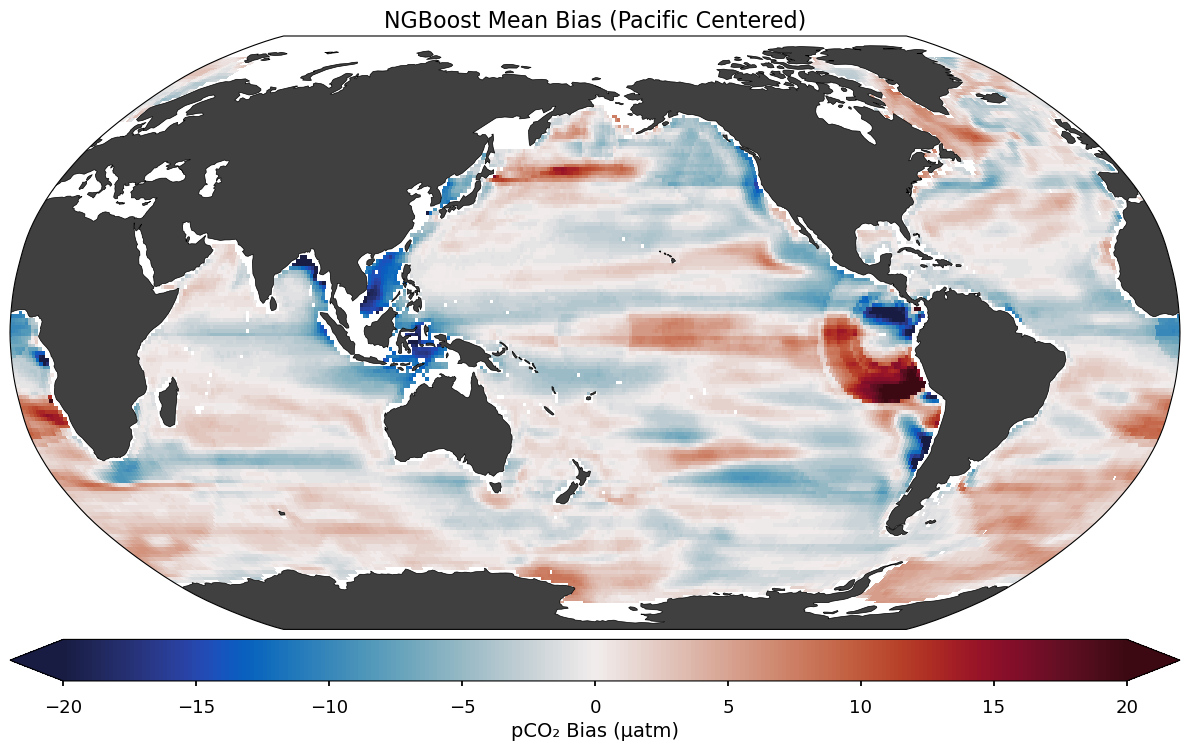

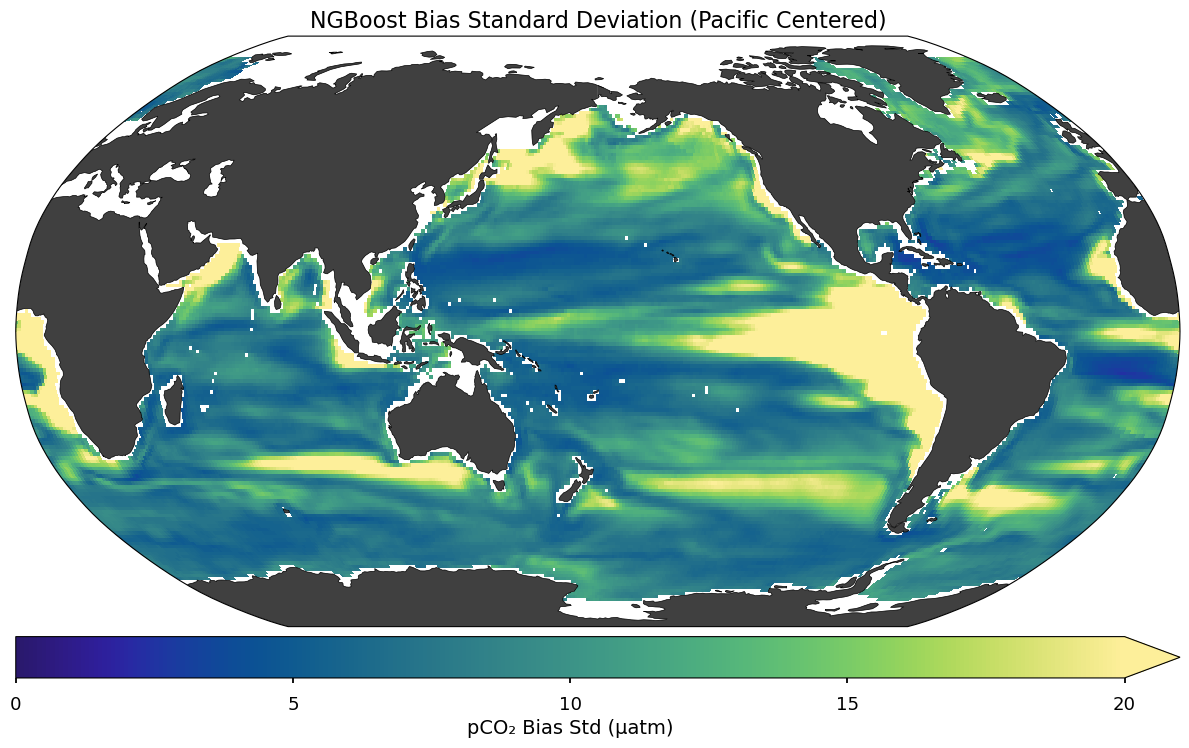

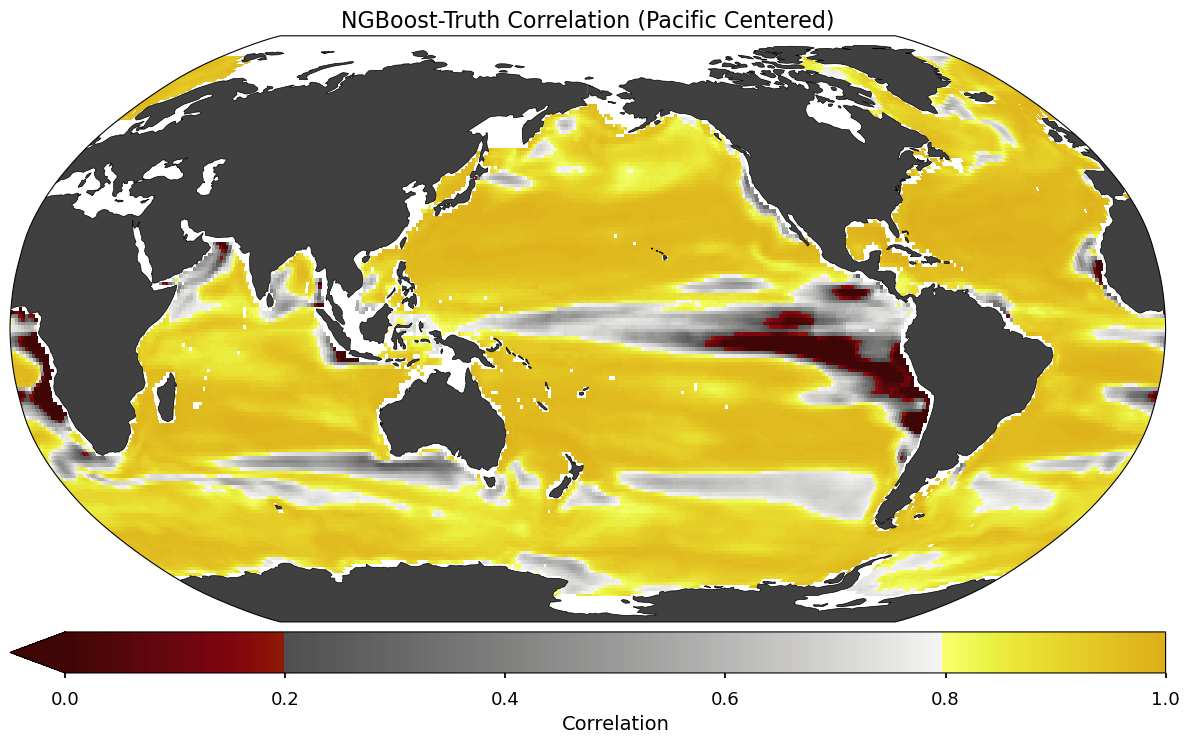

Global Mean Bias: -0.1209 µatm
Global Mean Std: 10.8716 µatm
Global Mean Correlation: 0.8495

Regional Statistics:
Region          Mean Bias  Mean Std   Correlation
--------------------------------------------------
Global               -0.12      10.87     0.8495
North Atlantic        0.34       8.88     0.9404
Tropical Pacific        nan        nan        nan
Southern Ocean        0.57       8.99     0.8688


In [6]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cmocean as cm
import pandas as pd
import gcsfs
from lib.visualization import SpatialMap2, xr_add_cyclic_point

# Set file paths
your_username = 'BokaiHe'  # Replace with your username
owner_username = 'BokaiHe'  # Replace with owner's username

# Date range
init_date = '200401'
fin_date = '202312'

# Select ESM and member to evaluate
ens = 'ACCESS-ESM1-5'
member = 'member_r10i1p1f1'

# File paths
base_dir = f'gs://leap-persistent/{your_username}/{owner_username}/pco2_residual/nmse/post02_xgb'
ngb_path = f"{base_dir}/reconstructions/{ens}/{member}/recon_pCO2_NGBoost_{ens}_{member}_mon_1x1_{init_date}_{fin_date}_new.zarr"

# Original ESM data path
ensemble_dir = "gs://leap-persistent/abbysh/pco2_all_members_1982-2023/00_regridded_members"
member_dir = f"{ensemble_dir}/{ens}/{member}"
member_path = f"{member_dir}/{ens}.{member.split('_')[-1]}.Omon.zarr"

# Create GCS filesystem object
fs = gcsfs.GCSFileSystem()

# Load datasets
try:
    # Load NGBoost reconstruction result
    ngb_ds = xr.open_zarr(ngb_path)
    print("Successfully loaded NGBoost reconstruction")

    # Load original ESM data
    esm_ds = xr.open_zarr(member_path)
    print("Successfully loaded original ESM data")

except Exception as e:
    print(f"Error loading data: {str(e)}")
    raise

# Define date range
date_range_start = '2004-01-01T00:00:00.000000000'
date_range_end = '2023-12-31T00:00:00.000000000'
dates = pd.date_range(start=date_range_start, end=date_range_end, freq='MS')

# Select same time range
esm_data = esm_ds["spco2"].sel(time=slice(str(dates[0]), str(dates[-1])))
ngb_data = ngb_ds["pCO2_recon_full"]

# Check dimensions for debugging
print(f"NGBoost data dims: {ngb_data.dims}, shape: {ngb_data.shape}")
print(f"ESM data dims: {esm_data.dims}, shape: {esm_data.shape}")

# 1. Compute bias
bias = ngb_data - esm_data
print(f"Bias dims: {bias.dims}, shape: {bias.shape}")

# 2. Compute mean bias
mean_bias = bias.mean(dim='time')

# 3. Compute standard deviation of bias (temporal variability)
std_bias = bias.std(dim='time')

# 4. Compute correlation using xarray
# Ensure alignment
corr = xr.corr(ngb_data, esm_data, dim='time')

# Shift longitude to center on the Pacific Ocean
def pacific_center(ds):
    # Add cyclic point
    ds_cyclic = xr_add_cyclic_point(ds, cyclic_coord='xlon')

    # Convert longitude to [-180, 180]
    ds_cyclic = ds_cyclic.assign_coords(xlon=(((ds_cyclic.xlon + 180) % 360) - 180))

    # Recenter so that 0° is at edge
    ds_pacific = ds_cyclic.assign_coords(xlon=(ds_cyclic.xlon + 180) % 360)

    # Sort by longitude
    ds_pacific = ds_pacific.sortby('xlon')

    return ds_pacific

# Apply Pacific-centered transformation
mean_bias_pacific = pacific_center(mean_bias)
std_bias_pacific = pacific_center(std_bias)
corr_pacific = pacific_center(corr)

# Use separate plots for each metric
plot_style = "seaborn-v0_8-talk"

# 1. Mean bias map
with plt.style.context(plot_style):
    fig = plt.figure(figsize=(12, 8))
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',
                           colorbar=True,
                           cbar_location='bottom')

    cmap_bias = cm.cm.balance
    vrange_bias = [-20, 20, 5]

    data = mean_bias_pacific
    sub = worldmap.add_plot(
        lon=data['xlon'], lat=data['ylat'], data=data,
        vrange=vrange_bias[0:2], cmap=cmap_bias, ax=0, linewidth_coast=0.5
    )
    worldmap.set_title("NGBoost Mean Bias (Pacific Centered)", ax=0, fontsize=16)
    col = worldmap.add_colorbar(sub, ax=0, extend='both')
    worldmap.set_cbar_xlabel(col, 'pCO₂ Bias (µatm)', fontsize=14)
    worldmap.set_ticks(col, vrange_bias[0], vrange_bias[1], vrange_bias[2])

    plt.tight_layout()
    plt.savefig(f"ngboost_mean_bias_pacific_{ens}_{member.split('_')[-1]}.png", dpi=300, bbox_inches='tight')
    plt.show()

# 2. Standard deviation of bias map
with plt.style.context(plot_style):
    fig = plt.figure(figsize=(12, 8))
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',
                           colorbar=True,
                           cbar_location='bottom')

    cmap_std = cm.cm.haline
    vrange_std = [0, 20, 5]

    data = std_bias_pacific
    sub = worldmap.add_plot(
        lon=data['xlon'], lat=data['ylat'], data=data,
        vrange=vrange_std[0:2], cmap=cmap_std, ax=0, linewidth_coast=0.5
    )
    worldmap.set_title("NGBoost Bias Standard Deviation (Pacific Centered)", ax=0, fontsize=16)
    col = worldmap.add_colorbar(sub, ax=0, extend='max')
    worldmap.set_cbar_xlabel(col, 'pCO₂ Bias Std (µatm)', fontsize=14)
    worldmap.set_ticks(col, vrange_std[0], vrange_std[1], vrange_std[2])

    plt.tight_layout()
    plt.savefig(f"ngboost_std_bias_pacific_{ens}_{member.split('_')[-1]}.png", dpi=300, bbox_inches='tight')
    plt.show()

# 3. Correlation map
with plt.style.context(plot_style):
    fig = plt.figure(figsize=(12, 8))
    worldmap = SpatialMap2(fig=fig, region='world', 
                           cbar_mode='single',
                           colorbar=True,
                           cbar_location='bottom')

    cmap_corr = cm.cm.oxy
    vrange_corr = [0, 1, 0.2]

    data = corr_pacific
    sub = worldmap.add_plot(
        lon=data['xlon'], lat=data['ylat'], data=data,
        vrange=vrange_corr[0:2], cmap=cmap_corr, ax=0, linewidth_coast=0.5
    )
    worldmap.set_title("NGBoost-Truth Correlation (Pacific Centered)", ax=0, fontsize=16)
    col = worldmap.add_colorbar(sub, ax=0, extend='min')
    worldmap.set_cbar_xlabel(col, 'Correlation', fontsize=14)
    worldmap.set_ticks(col, vrange_corr[0], vrange_corr[1], vrange_corr[2])

    plt.tight_layout()
    plt.savefig(f"ngboost_correlation_pacific_{ens}_{member.split('_')[-1]}.png", dpi=300, bbox_inches='tight')
    plt.show()

# 4. Compute global statistics - use original (non-Pacific-centered) data
ocean_mask = ~np.isnan(mean_bias)

# Compute global statistics
global_mean_bias = float(mean_bias.where(ocean_mask).mean().values)
global_mean_std = float(std_bias.where(ocean_mask).mean().values)
global_mean_corr = float(corr.where(ocean_mask).mean().values)

# Print global stats
print(f"Global Mean Bias: {global_mean_bias:.4f} µatm")
print(f"Global Mean Std: {global_mean_std:.4f} µatm")
print(f"Global Mean Correlation: {global_mean_corr:.4f}")

# Regional statistics table
regions = {
    "Global": ([-90, 90], [-180, 180]),
    "North Atlantic": ([20, 60], [-80, 0]),
    "Tropical Pacific": ([-10, 10], [120, -70]),
    "Southern Ocean": ([-70, -40], [-180, 180]),
}

region_stats = []
for region_name, (lat_range, lon_range) in regions.items():
    # Select region
    region_sel = (
        (mean_bias.ylat >= lat_range[0]) & 
        (mean_bias.ylat <= lat_range[1]) & 
        (mean_bias.xlon >= lon_range[0]) & 
        (mean_bias.xlon <= lon_range[1])
    )

    # Compute statistics for region
    region_mean_bias = float(mean_bias.where(region_sel & ocean_mask).mean().values)
    region_mean_std = float(std_bias.where(region_sel & ocean_mask).mean().values)
    region_mean_corr = float(corr.where(region_sel & ocean_mask).mean().values)

    region_stats.append([
        region_name,
        region_mean_bias,
        region_mean_std,
        region_mean_corr
    ])

# Print regional stats table
print("\nRegional Statistics:")
print(f"{'Region':<15} {'Mean Bias':<10} {'Mean Std':<10} {'Correlation':<10}")
print("-" * 50)
for stat in region_stats:
    print(f"{stat[0]:<15} {stat[1]:10.2f} {stat[2]:10.2f} {stat[3]:10.4f}")